In [ ]:
# NOTES
# if not running in local dev environment (perceval_venv / health-env):
#
# Install a pip package in the current Jupyter kernel
# >import sys
# >!{sys.executable} -m pip install grimoirelab
#
# Command line usage: 
# >!pip3 install grimoirelab
# >!perceval git 'https://github.com/bitcoin/bitcoin.git' --from-date '2021-07-14'
#
# web tutorial: https://chaoss.github.io/grimoirelab-tutorial/perceval/git.html
# perceval docs: https://perceval.readthedocs.io/en/latest/

In [5]:
#from perceval.backends.core.git import Git
from datetime import datetime
import dateutil.rrule
import dateutil.tz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import time
import csv

# file I/O for running a colab notebook
#from google.colab import files

In [19]:
repo_btc = 'https://github.com/bitcoin/bitcoin.git'

# urls for the git repo to analyze
repos = [
          [ 'bitcoin',     'https://github.com/bitcoin/bitcoin.git'],
          [ 'go_ethereum', 'https://github.com/ethereum/go-ethereum.git'],
          [ 'cardano',     'https://github.com/input-output-hk/cardano-node.git'],
          [ 'polkadot',    'https://github.com/paritytech/polkadot.git'],
          [ 'ripple',      'https://github.com/ripple/rippled.git'],
          [ 'uniswap_v2',  'https://github.com/Uniswap/uniswap-v2-core.git'],
          [ 'uniswap_v3',  'https://github.com/Uniswap/uniswap-v3-core.git'],
          [ 'link',        'https://github.com/smartcontractkit/chainlink.git'],
          [ 'stellar-core','https://github.com/stellar/stellar-core'],
          [ 'dogecoin',    'https://github.com/dogecoin/dogecoin'],
          [ 'filecoin',    'https://github.com/filecoin-project/lotus'],
          [ 'substrate',   'https://github.com/paritytech/substrate'],
          [ 'discord',     'https://github.com/discordjs/discord.js'],
          [ 'apache-spark','https://github.com/apache/spark'],
          [ 'rust',        'https://github.com/rust-lang/rust'],
        ]
repos2 = [
          [ 'bitcoin',    'https://github.com/bitcoin/bitcoin.git'],
          [ 'go_ethereum','https://github.com/ethereum/go-ethereum.git'],
          [ 'dogecoin',    'https://github.com/dogecoin/dogecoin'],
        ]


#[ 'perceval',   'http://github.com/grimoirelab/perceval.git'],

# complete date options
# fromDate = datetime.datetime(2021, 7, 14, 0, 0, 0,tzinfo=dateutil.tz.tzutc())
# fromDate = datetime.datetime(2018, 7, 1) # from is inclusive
# toDate = datetime.datetime(2021, 6, 30)  # not sure if to is inc. or excl.

In [2]:
def fetchTimezones(repoURL, repoName, from_Date, to_Date):
    # directory for letting Perceval clone the git repo
    # must be unique for the repo because it is reused
    # Date format is 'YYYY,MM,DD'
    dir_string = '/tmp/'+repoName+'.git'
    repo_dir = dir_string

    # create a Git object, pointing to repo_url: the github repo path
    # and repo_dir: the local path for cloning
    repo_object = Git(uri = repoURL, gitpath = repo_dir)
    count = 0
    noTZ = 0
    #rawData = []
    timeData = []
    #res = 0
    for commit in repo_object.fetch(from_date = from_Date, to_date = to_Date):
        # handy for storing all data
        #rawData.append(commit)
        count += 1
        # commit date is a string
        time = commit['data']['CommitDate']
        
        # this is now an aware date object and can be universally sequenced
        dateTimeObject = datetime.strptime(' '.join(time.split(' ')), '%a %b %d %H:%M:%S %Y %z')
        
        # convert to an offset in hours
        offset = dateTimeObject.utcoffset().seconds // 3600
        
        # NZ is UTC+12 (ahead); +13 is also -11 geographically, or 13-24=-11 
        # due to polar plotting all >12 shifted by -24, so:
        # +12 -> -12: e.g NZ
        # +13 -> -11: Tokelau, Samoa, Tonga (Midway, Niue are already -11)
        # +14 -> -10: Christmas Island, Kiwibati  
        # half-hour offsets are taken as the floor, e.g. India (+5.5) -> +5
        if offset > 11:
            offset = offset - 24
        timeData.append(offset)
        
        if count % 1000 == 0:
            print('.', end='')
        
    # stats
    if count > 0: percentage = (noTZ/count)*100
    else: percentage = 0
    # maybe later write these to the header
    # >check that 0.5 timezone offsets get binned
    print('finished fetching data from:', repoName)
    print('total commits counted:', count)
    print('number with null timezone:', noTZ, '(', round(percentage, 1),'%)')

    # return the list of timezone offsets
    return timeData
    #return rawData

In [71]:
def fetchTimeZonesArray(repoURL, repoName, from_Date, to_Date):
    # directory for letting Perceval clone the git repo
    # must be unique for the repo because it is reused
    # Date format is 'YYYY,MM,DD'
    dir_string = '/tmp/'+repoName+'.git'
    repo_dir = dir_string

    # create a Git object, pointing to repo_url: the github repo path
    # and repo_dir: the local path for cloning
    repo_object = Git(uri = repoURL, gitpath = repo_dir)
    count = 0
    noTZ = 0
    # timeData array(list) has 1 position for each timezone
    timeData = [0] * 24
    #res = 0
    for commit in repo_object.fetch(from_date = from_Date, to_date = to_Date):
        # handy for storing all data
        #rawData.append(commit)
        count += 1
        # commit date is a string
        time = commit['data']['CommitDate']
        
        # this is now an aware date object and can be universally sequenced
        dateTimeObject = datetime.strptime(' '.join(time.split(' ')), '%a %b %d %H:%M:%S %Y %z')
        
        # convert to an offset in hours
        offset = dateTimeObject.utcoffset().seconds // 3600
        
        # NZ is UTC+12 (ahead); +13 is also -11 geographically, or 13-24=-11 
        # due to polar plotting all >12 shifted by -24, so:
        # +12 -> -12: e.g NZ
        # +13 -> -11: Tokelau, Samoa, Tonga (Midway, Niue are already -11)
        # +14 -> -10: Christmas Island, Kiwibati  
        # half-hour offsets are taken as the floor, e.g. India (+5.5) -> +5
        if offset > 11:
            offset = offset - 24
        
        # increment timeData[offset] counter
        timeData[offset+12] += 1
        
        if count % 1000 == 0:
            print('.', end='')
        
    # stats
    if count > 0: percentage = (noTZ/count)*100
    else: percentage = 0
    # maybe later write these to the header
    # >check that 0.5 timezone offsets get binned
    print('finished fetching data from:', repoName)
    print('total commits counted:', count)
    if noTZ != 0: print('number with null timezone:', noTZ, '(', round(percentage, 1),'%)')

    # return the list of timezone offsets
    return timeData
    #return rawData

In [67]:
#timeData = [0] * 24
#for i in range(24):
    # You can add your timezone data for each index
offset = 11
for i in range(117):
    timeData[offset+12] += 1
    
    

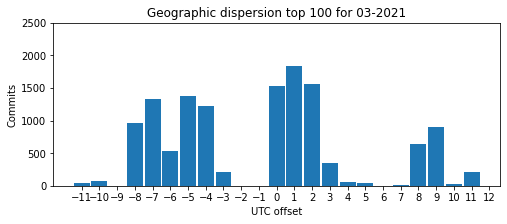

In [33]:
# required data is a list of timezone offsets of any length
# offsets must be between -12 and +12 inclusive
#
# just for testing
def plotUTCHistogram(data, month):
    # offset by half unit so ticks are in the middle of the bar
    bins = np.linspace(-11, 12, 24) -0.5
    xticks = np.linspace(-11, 12, 24)
    plt.figure(figsize=(8,3))
    plot = plt.hist(data, bins = bins, rwidth = 0.9)
    plt.ylim(0, 2500)
    plt.xticks(xticks)
    plt.xlabel("UTC offset")
    plt.ylabel("Commits")
    title = 'Geographic dispersion top 100 for ' + month
    plt.title(title)
    filename = 'month_histo_' + month
    plt.savefig(filename, dpi = 300)
    plt.show()
    
plotUTCHistogram(df1,'03-2021')

In [264]:
# required data is a list of timezone offsets of any length
# offsets must be between -12 and +11.5; [-12,12)
# not tested as extentively as the Area plot
def plotUTCPolarHistogram(data, 
                          repo, 
                          logR=None, 
                          writePlot=None, 
                          fromDate=None, 
                          toDate=None):
    N = 24
    plt.figure(figsize=(5,5))
    bins = np.linspace(-12, 12, N+1)
    # extract histogram counts in plot object
    plot = plt.hist(data,bins=bins) 
   
    #radius or magnitude values
    r = plot[0]
    # 24 hour bins (hour 24 is hour 0, or -12 = +12)
    theta = np.linspace(-np.pi, np.pi, N, endpoint=False)
    width = (1.8*np.pi) / N

    ax = plt.subplot(111, polar=True)

    # logR argument: for a log scale
    if (logR == None) or (logR == False):
        # DEFALT For a linear scale
        # radial shift from centre as a proportion of the whole
        bottom = max(plot[0])*0.35
    elif logR == True:
        bottom = 0.05

    # have to offset radius by pi radians; no idea why
    bars = ax.bar(theta + np.pi, r, width=width, bottom=bottom)   

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    # Set axes for a log scale
    if logR == True:
        ax.set_rmin(0.1)
        ax.set_rscale('log')
        
    # Set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    # custom labels
    ax.set_xticklabels([r'$\pm 12$', r'$-11$', r'$-10$', r'$-9$', r'$-8$', r'$-7$', r'$-6$', r'$-5$', r'$-4$', r'$-3$', r'$-2$', r'$-1$', r'UTC', r'$+1$', r'$+2$', r'$+3$', r'$+4$', r'$+5$', r'$+6$', r'$+7$', r'$+8$', r'$+9$', r'$+10$', r'$+11$'])    
    # Make the labels go clockwise
    ax.set_theta_direction(-1)       
    # Place 0 at the top
    ax.set_theta_offset(-np.pi/2)    
    #ax.grid(False) #turn off grid lines
    ax.grid(alpha=0.4) #fade grid lines   

    # Use custom colors and opacity
    for r, bar in zip(theta, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.8)

    # title 
    diff = toDate - fromDate
    months = round((diff.days / 365 *12), 1)
    title = repo + \
            ' Geographic Dispersion for ' + \
            str(months) + ' months to ' + \
            str(toDate.month) + '-' + str(toDate.year)
    plt.title(title)

    # output plot
    if writePlot == True:
        plotFilename = 'plots/' + 'polar_' + repo + '_' + \
        str(fromDate.month)+'-'+str(fromDate.year) + '_to_' + \
        str(toDate.month)+'-'+str(toDate.year) + '.png'
        plt.savefig(plotFilename, facecolor='w', dpi = 300)
    
    #return plot

In [9]:
# required data is a list of timezone offsets of any length
# offsets must be between -12 and +11.5; [-12,12)
def plotUTCPolarHistogramArea(data, 
                              repo, 
                              writePlot=None, 
                              magnitudeLabels=False, 
                              fromDate=None, 
                              toDate=None):
    
    # check data list - cannot contain +12, can only contain [-12,12)
    # this is necessary for polar plotting purposes (data will still plot but be incorrect)
    if max(data) >= 12:
        raise Exception("data list contains UTC offsets >= +12, the acceptable range is [-12,12)")
    
    # seaborn package formatting
    sns.set_style("darkgrid")
    sns.set_context("paper")
    
    plt.figure(figsize=(5,5))
    
    # right hand bin edge is included, i.e. [11,12] is the last bin
    N = 24
    bins = np.linspace(-12, 12, N+1)
    # 24 hour bins (hour 24 is hour 0, or -12 = +12)
    theta = np.linspace(-np.pi, np.pi, N, endpoint=False)
    width = (1.8*np.pi) / N

    ax = plt.subplot(111, polar=True)

    # bin data for our polar histogram
    counts, bin = np.histogram(data, bins=bins)

    # for a donut centre
    constRatio = largestCount = max(counts)/len(data)
    # can't figure out a constant offset here...
    ax.set_rorigin(-0.1)

    # Normalise counts to compute areas
    area = counts / len(data)
    # Compute corresponding radii from areas
    r = (area / np.pi)**.5
    
    # have to offset radius by pi radians; no idea why
    bars = ax.bar(theta + np.pi, r, width=width)
    
    #
    # have to sort out the y axis another day...
    #
    #peak = max(counts) / len(data)
    #print('max count:',str(max(counts)),', len data: ',str(len(data)),' peak:',peak)
    #y_pos = np.linspace(0, peak, 2, endpoint=False)
    #ax.set_yticks(y_pos)
    #ax.set_yticklabels([0, ax.get_rmax()])
    #ylim=ax.get_ylim()
    #rmax=ax.get_rmax()
    #print('ylim: ',str(ylim),' rmax: ',str(rmax))
        
    # radial magnitude scale labels
    if magnitudeLabels == False:
        magnitude = False
    else: magnitude = True
    plt.setp(ax.get_yticklabels(), visible=magnitude)
        
    # Set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))      
    # custom labels
    ax.set_xticklabels([r'$\pm 12$', r'$-11$', r'$-10$', r'$-9$', r'$-8$', r'$-7$', r'$-6$', r'$-5$', r'$-4$', r'$-3$', r'$-2$', r'$-1$', r'UTC', r'$+1$', r'$+2$', r'$+3$', r'$+4$', r'$+5$', r'$+6$', r'$+7$', r'$+8$', r'$+9$', r'$+10$', r'$+11$'])   
    # Make the labels go clockwise
    ax.set_theta_direction(-1)       
    # Place 0 at the top
    ax.set_theta_offset(-np.pi/2)   
    #ax.grid(False) #turn off grid lines
    #ax.grid(alpha=0.4) #fade grid lines   

    # Use custom colors and opacity
    for r, bar in zip(theta, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.77)
    
    # title -- might not work without dates being passed
    diff = toDate - fromDate
    months = round((diff.days / 365 *12), 1)
    title = repo + \
            ' Geographic Dispersion for ' + \
            str(months) + ' months to ' + \
            str(toDate.month) + '-' + str(toDate.year)
    plt.title(title)

    # output plot
    if writePlot == True:
        plotFilename = 'plots/' + 'polar_' + repo + '_' + \
            str(fromDate.month)+'-'+str(fromDate.year) + '_to_' + \
            str(toDate.month)+'-'+str(toDate.year) + '.png'
        plt.savefig(plotFilename, facecolor='w', dpi = 300)
    
    # end plotUTCPolarHistogramArea method

In [ ]:
# plot function call
plotUTCPolarHistogramArea(sampleData, 'repoName', True, False, fromDate, toDate)

In [ ]:
fromDate = datetime.datetime(2021, 7, 1) # from is inclusive
toDate = datetime.datetime(2021, 7, 15)  # not sure if to is inc. or excl.

# individual main loop
# takes 21 minutes for the first time to clone all repos etc.
# 
for project in repos:
    repoName = project[0]
    repoURL  = project[1]
    data = fetchTimezones(repoURL, repoName, fromDate, toDate)
    
    # create plot object
    #print(repoName, repoURL)
    plotUTCPolarHistogramArea(data, repoName, True, False, fromDate, toDate)

    # output data
    dataFilename = repoName + '_tz_data.csv'
    df = pd.DataFrame(data)
    df.to_csv(dataFilename, encoding='utf-8', index=False)

In [95]:
repos = pd.read_csv('subset100.csv')
repo10 = repos[:10].copy()
for index, row in repo10.iterrows():
    repoName = row['name']
    repoURL = row['url']
    print(repoName, repoURL)


Bitcoin https://github.com/bitcoin/bitcoin
Ethereum https://github.com/ethereum/go-ethereum
BNB https://github.com/bnb-chain/bsc
USD Coin https://github.com/centrehq/centre-tokens
XRP https://github.com/ripple/rippled
Terra https://github.com/terra-project/core
Cardano https://github.com/input-output-hk/cardano-node
Solana https://github.com/solana-labs/solana
Avalanche https://github.com/ava-labs/avalanchego
Polkadot https://github.com/paritytech/polkadot


In [96]:
repo10

,name,url
0,Bitcoin,https://github.com/bitcoin/bitcoin
1,Ethereum,https://github.com/ethereum/go-ethereum
2,BNB,https://github.com/bnb-chain/bsc
3,USD Coin,https://github.com/centrehq/centre-tokens
4,XRP,https://github.com/ripple/rippled
5,Terra,https://github.com/terra-project/core
6,Cardano,https://github.com/input-output-hk/cardano-node
7,Solana,https://github.com/solana-labs/solana
8,Avalanche,https://github.com/ava-labs/avalanchego
9,Polkadot,https://github.com/paritytech/polkadot


In [ ]:
#reposT = [
#          [ 'bitcoin',    'https://github.com/bitcoin/bitcoin.git'],
#          [ 'go_ethereum','https://github.com/ethereum/go-ethereum.git'],
#          [ 'dogecoin',    'https://github.com/dogecoin/dogecoin'],
#         ]

fromDate = datetime(2021, 6, 1) # from is inclusive
toDate = datetime(2021, 7, 15)  # to is exclusive
    
# cumulative main loop
# make a default df
allData = pd.DataFrame()
#total = pd.DataFrame()

for index, row in repo10.iterrows():
    repoName = row['name']
    print('repoName: '+repoName)
    repoURL = row['url']
    data = fetchTimeZonesArray(repoURL, repoName, fromDate, toDate) 

    # concatenate data
    df = pd.DataFrame(data)
    #total = total.append(df, ignore_index = True)
    df.columns = [repoName]
    allData = pd.concat([allData, df], axis=1)
    
# create plot object // doesn't work with fetchTimeZonesArray() method
# plotUTCPolarHistogramArea(data, repoName, True, False, fromDate, toDate)

In [ ]:
# potentially usefull stuffs
df['avg'] = df.mean(axis=1)
dfnorm.fillna(0, inplace=True)
df = df.drop(columns=['sum_norm'])
print(df['Wrapped Bitcoin'])

# replace any NaN values
dfnorm.fillna(0, inplace=True)

# these are the same calculation and produce the same results
df = df.assign(sum_norm = lambda x: (x["sum"] - x["sum"].min()) / (x["sum"].max() - x["sum"].min()))
df = df.assign(avg_norm = lambda x: (x["avg"] - x["avg"].min()) / (x["avg"].max() - x["avg"].min()))

In [68]:
#-------------------------------------------
# Calculate TimeZone baseline and apply to all projects
#-------------------------------------------
# RMSD or RMSE seems like a good candidate
# from wikipedia https://en.wikipedia.org/wiki/Root-mean-square_deviation
# In imaging science, the RMSD is part of the peak signal-to-noise ratio, a measure used to assess how well a method to reconstruct an image performs relative to the original image.
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

#-------------------------------------------
# average of top 100
#-------------------------------------------
df1 = pd.read_csv('allData100.csv')

# exclude zero-commit projects
df1 = df1.loc[:, (df1 != 0).any(axis=0)]

# find average
df1['avg'] = df1.mean(axis=1)

# normalize. This is the column to use for comparison
df1 = df1.assign(avg_norm = lambda x: (x["avg"] - x["avg"].min()) / (x["avg"].max() - x["avg"].min()))

#-------------------------------------------
# calculate RMSE for top 600
#-------------------------------------------

# read in raw timezone data
df6 = pd.read_csv('allData600.csv')

# create normalized dataframe
dfnorm = (df6 - df6.min()) / (df6.max() - df6.min())

# replace any NaN values
dfnorm.fillna(0, inplace=True)

# temp df
results_df = pd.DataFrame(columns=["url", "rmse", "mae"])

for column in dfnorm.columns:
    if column != "avg_norm": #exclude the normalized column
        # pearson
        #correlation, _ = pearsonr(df["avg_norm"], df[column])
        rmse = mean_squared_error(df1["avg_norm"], dfnorm[column])**0.5
        mae = mean_absolute_error(df1["avg_norm"], dfnorm[column])
        #print("{:<25} {:<25} {:<25}".format(column, rmse, mae))
       
        # Append the results to the DataFrame
        temp_df = pd.DataFrame({"url": [column], "rmse": [rmse], "mae": [mae]})
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

# write out        
results_df.to_csv("geo600.csv", index=False)
# merged dataframes (manually check in excel; need to remove 'url' column)
df1 = pd.read_csv('geo600.csv')
dfm = pd.read_csv('merged_updated_20-Jan-2023.csv')
merged_df = pd.merge(dfm, df1, left_on='source_code', right_on='url', how='left')

In [70]:
df1['avg_norm'].to_csv("avg_norm_data.csv", index=False)

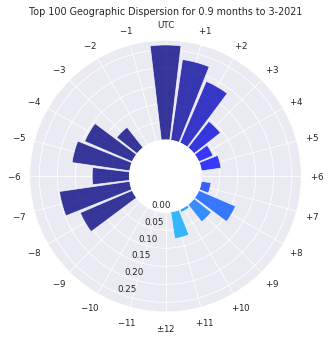

In [200]:
fromDate = datetime(2021, 3, 1) # from is inclusive
toDate = datetime(2021, 3, 28)  # to is exclusive.
plotUTCPolarHistogramArea(total, 'Top 100', False, True, fromDate, toDate)


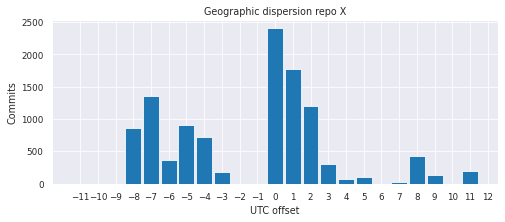

In [198]:
plotUTCHistogram(total)

In [ ]:
# useful for testing or traditional viewpoint, includes scale
for column in allData:
    plotUTCHistogram(allData[column])

In [63]:
for row in subset2.itertuples():
    repoName = row[0]
    repoURL  = row[1]
  

Bitcoin, https://github.com/bitcoin/bitcoin
Ethereum, https://github.com/ethereum/go-ethereum


In [213]:
# take a subset of top 100 crypto repos by rank
# get commit data for 1 month: April 2022 and take the aggregate view
# work backwards for monthly view to see if its changing
subset100 = pd.read_csv('subset100.csv', index_col=0)

In [224]:
# fromDate = datetime(2022, 3, 1) # from is inclusive
# toDate = datetime(2022, 3, 28)  # to is exclusive.

# cumulative main loop
# concatenated for baseline
# make a default df

def getTimeZoneMonth(month, year):
    fromDate = datetime(year, month, 1) # from is inclusive
    if month == 12:
        toDate = datetime(year+1, (month+1)%12, 1)  # to is exclusive.
    else: 
        toDate = datetime(year, month+1, 1)
        
    allData = pd.DataFrame()
    total = pd.DataFrame()
    start = datetime.now()
    for row in subset100.itertuples():
        repoName = row[0]
        print('Repo Name: '+repoName)
        repoURL  = row[1]

        # go to Perceval to fetch the data
        data = fetchTimezones(repoURL, repoName, fromDate, toDate) 
        df = pd.DataFrame(data) 
        total = total.append(df, ignore_index = True)

        # most of time there is commit data (non-empty)
        if not df.empty:    
            df.columns = [repoName]
        else:
            # catch the case of no data (empty df) being returned
            # need to add an empty column with proper name
            df = pd.DataFrame(data=None, columns=[repoName])

        allData = pd.concat([allData, df], axis=1, sort=False)

    # some log info
    # now = datetime.now()
    # elapsed = (now - start).total_seconds() / 60
    # output = 'Query took ' + str(round(elapsed,2)) + ' minutes.'
    # print('\n' + output)

    # this is the cumulative dataframe to deduce a standard
    # total.info()
    totalOut = str(year)+'-'+str(month)+'-total.csv'
    total.to_csv(totalOut, index=False, encoding='utf-8')

    # is is the individual repos in a dataframe
    # allData.info()
    allDataOut = str(year)+'-'+str(month)+'-repos.csv'
    allData.to_csv(allDataOut, index=False, encoding='utf-8')

In [ ]:
getTimeZoneMonth(12, 2021)
getTimeZoneMonth(1, 2022)
getTimeZoneMonth(2, 2022)
getTimeZoneMonth(3, 2022)

In [22]:
df1 = pd.read_csv('2021-3-total.csv')
df2 = pd.read_csv('2021-4-total.csv')
df3 = pd.read_csv('2021-5-total.csv')
df4 = pd.read_csv('2021-6-total.csv')
df5 = pd.read_csv('2021-7-total.csv')
df6 = pd.read_csv('2021-8-total.csv')
df7 = pd.read_csv('2021-9-total.csv')
df8 = pd.read_csv('2021-10-total.csv')
df9 = pd.read_csv('2021-11-total.csv')
df10 = pd.read_csv('2021-12-total.csv')
df11 = pd.read_csv('2022-1-total.csv')
df12 = pd.read_csv('2022-2-total.csv')

In [ ]:
plotUTCHistogram(df1,'03-2021')
plotUTCHistogram(df2,'04-2021')
plotUTCHistogram(df3,'05-2021')
plotUTCHistogram(df4,'06-2021')
plotUTCHistogram(df5,'07-2021')
plotUTCHistogram(df6,'08-2021')
plotUTCHistogram(df7,'09-2021')
plotUTCHistogram(df8,'10-2021')
plotUTCHistogram(df9,'11-2021')
plotUTCHistogram(df10,'12-2021')
plotUTCHistogram(df11,'01-2022')
plotUTCHistogram(df12,'02-2022')

In [72]:
# test cell // used to use datetime.datetime()
fromDate = datetime(2020, 1, 1) # from is inclusive
toDate = datetime(2021, 7, 1)  # to is exclusive.
#data = fetchTimezones('https://github.com/bitcoin/bitcoin.git', 'bitcoin', fromDate, toDate)
data = fetchTimeZonesArray('https://github.com/SyntropyNet/syntropy-agent.git', 'Syntropy', fromDate, toDate)
#data = fetchTimezones('https://github.com/ethereum/go-ethereum.git', 'go-eth', fromDate, toDate)
#data = fetchTimezones('https://github.com/rust-lang/rust.git', 'Rust', fromDate, toDate)
#plotUTCPolarHistogram(data, 'go_ethereum')
#data = fetchTimezones('https://github.com/rust-lang/rust', 'rust', fromDate, toDate)
#data = fetchTimezones('https://github.com/input-output-hk/cardano-node.git', 'cardano', fromDate, toDate)

finished fetching data from: Syntropy
total commits counted: 433


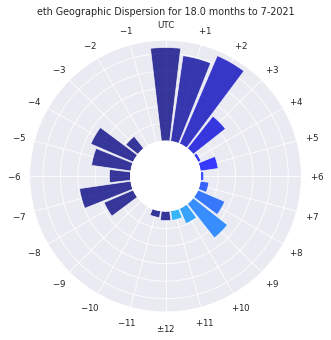

In [24]:
plotUTCPolarHistogramArea(data, 'eth', True, False, fromDate, toDate)